In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging, pickle
logging.basicConfig(filename='./_logs/exp-2-simulations.log',level=logging.DEBUG)
from itertools import product
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyrlap.domains.gridworld import GridWorld
from demoteaching.mdps.discretizedobmdp import DiscretizedObserverBeliefMDPApproximation

In [32]:
%load_ext rpy2.ipython
import scipy
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

In [252]:
exp_trials = pd.read_pickle('../data/exp2-trials.pd.pkl')
exp_trials_stats = pd.read_pickle("./_comps/exp-trials-stats.pd.pkl")
exp_trajs = pd.read_pickle("./_comps/exp-trajs.df.pkl")
sim_trajs = pd.read_pickle("./_comps/sim-trajs.df.pkl")
grid_params = pd.read_pickle("../data/exp2-grid_params.df.pkl")

## Analysis of experimental trajectories alone

In [274]:
jump_df = exp_trials_stats[['grid', 'cond', 'participant', 'is_jump', 'tf']].\
    groupby(['participant', 'cond', 'grid', 'tf'])['is_jump'].sum().reset_index() #get jump count per round
riskyjump_df = exp_trials_stats[exp_trials_stats['is_jump']][['grid', 'cond', 'participant', 'is_risky_jump', 'tf']].reset_index()

In [254]:
%%R -i riskyjump_df,jump_df -o riskyjump_mod,jump_mod
library(lme4)
library(lmerTest)
jump_mod <- lmer(
    is_jump ~ cond + (1 | participant) + (1 | grid:tf),
    data=jump_df,
    REML=F
)
riskyjump_mod <- glmer(
    is_risky_jump ~ cond + (1 | participant) + (1 | grid:tf),
    data=riskyjump_df,
    family=binomial(link="logit"),
    REML=F
)

/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "grid". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "cond". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "participant". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "tf". Fall back to string conversion.

In [255]:
# print(ro.r('summary(jump_mod)'))
print(ro.r('summary(jump_mod)$coefficients'))
print(ro.r('summary(riskyjump_mod)$coefficients'))

            Estimate Std. Error       df  t value     Pr(>|t|)
(Intercept) 1.024038  0.1220776 65.54703 8.388424 5.617653e-12
condshow    0.712242  0.1364308 79.70832 5.220537 1.386399e-06

              Estimate Std. Error   z value     Pr(>|z|)
(Intercept) -1.8034006  0.4891530 -3.686782 2.271078e-04
condshow     0.9782332  0.2353166  4.157094 3.223213e-05



### analysis comparing simulated predictions to human data

In [256]:
#analysis comparing simulated predictions to human data
sim_items = sim_trajs.groupby(['cond', "grid", "tf"])[
    ["jumps_per_traj", "n_jumps", "risky_jumps_per_jump", "b.target"]].mean().reset_index()

#jumping dataframe for linear regression
jump_df = exp_trials_stats[['grid', 'cond', 'participant', 'is_jump', 'tf']].\
    groupby(['participant', 'cond', 'grid', 'tf'])['is_jump'].sum().reset_index() #get jump count per round
jump_df = jump_df.rename(columns={'is_jump': 'n_jumps'})
jump_df = jump_df.merge(sim_items[['cond', 'grid', 'tf', 'n_jumps']], on=['cond', 'grid', 'tf'], suffixes=('_exp', '_sim'))

#risky jumping df for logistic regression
riskyjump_df = exp_trials_stats[exp_trials_stats['is_jump']][['grid', 'cond', 'participant', 'is_risky_jump', 'tf']].reset_index()
riskyjump_df = riskyjump_df.rename(columns={'is_risky_jump': 'risky_jumps_per_jump'})
riskyjump_df = riskyjump_df.merge(sim_items[['cond', 'grid', 'tf', 'risky_jumps_per_jump']], on=['cond', 'grid', 'tf'], suffixes=('_exp', '_sim'))

In [258]:
%%R -i jump_df,riskyjump_df -o jump_mod,riskyjump_mod
library(lme4)
library(lmerTest)
jump_mod <- lmer(
    n_jumps_exp ~ n_jumps_sim + (1 | participant) + (1 | grid:tf),
    data=jump_df,
    REML=F
)
riskyjump_mod <- glmer(
    risky_jumps_per_jump_exp ~ risky_jumps_per_jump_sim + (1 | participant) + (1 | grid:tf),
    data=riskyjump_df,
    family=binomial(link="logit"),
    REML=F
)

/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "participant". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "cond". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "grid". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "tf". Fall back to string conversion.

In [259]:
print(ro.r("summary(jump_mod)$coefficients"))
print(ro.r("summary(riskyjump_mod)$coefficients"))

             Estimate Std. Error       df  t value     Pr(>|t|)
(Intercept) 1.0024400 0.14017680 104.4106 7.151254 1.221497e-10
n_jumps_sim 0.2931735 0.07095497 587.7544 4.131825 4.121804e-05

                          Estimate Std. Error   z value     Pr(>|z|)
(Intercept)              -2.355736  0.3988013 -5.907042 3.483043e-09
risky_jumps_per_jump_sim  2.587580  0.4179283  6.191444 5.961544e-10



```
\linregfixed{0.29}{0.07}{587.75}{4.13}{<.0001}
\logregfixed{2.58}{0.42}{6.19}{<10^{-9}}
```

### analysis to compare full showing model with lesioned showing model

In [365]:
#only show trials
show_trials_stats = exp_trials_stats[exp_trials_stats['cond'] == 'show']
do_trials_stats = exp_trials_stats[exp_trials_stats['cond'] == 'do']

#model predictions by item
model_jumps = sim_items.pivot_table(columns=['cond'], index=['tf', 'grid'], values='n_jumps').reset_index()
model_riskyjumps = sim_items.pivot_table(columns=['cond'], index=['tf', 'grid'], values='risky_jumps_per_jump').reset_index()

#align model predictions to trials
jump_df = show_trials_stats[['cond', 'participant', 'grid', 'tf', 'is_jump']].\
    groupby(['participant', 'grid', 'tf'])['is_jump'].sum().reset_index() #get jump count per round
jump_df = jump_df.rename(columns={'is_jump': 'n_jumps'})
jump_df = jump_df.merge(model_jumps, on=['grid', 'tf'], suffixes=('_exp', '_sim'))

riskyjump_df = show_trials_stats[show_trials_stats['is_jump']][['cond', 'grid', 'participant', 'is_risky_jump', 'tf']].reset_index(drop=True)
riskyjump_df = riskyjump_df.merge(model_riskyjumps, on=['grid', 'tf'], suffixes=('_exp', '_sim'))

risky_jump_dodf = do_trials_stats[do_trials_stats['is_jump']][['cond', 'grid', 'participant', 'is_risky_jump', 'tf']].reset_index(drop=True)
risky_jump_dodf = risky_jump_dodf.merge(model_riskyjumps, on=['grid', 'tf'])
risky_jump_dodf['show'] = risky_jump_dodf['do']
risky_jump_dodf['show-noint'] = risky_jump_dodf['do']

riskyjump_df = pd.concat([riskyjump_df, risky_jump_dodf])
riskyjump_df = riskyjump_df.rename(columns={'show-noint': 'show_noint'})

In [395]:
%%R -i riskyjump_df -o riskyjump_mod
#test to see if risky jump is better predicted by full show model
library(lme4)
library(lmerTest)
show_noint_mod <- glmer(
    is_risky_jump ~ show_noint + (1 | participant) + (1 | grid:tf) + (1| grid),
    data=riskyjump_df,
    family=binomial(link="logit"),
    REML=F
)
show_full_mod <- glmer(
    is_risky_jump ~ show + (1 | participant) + (1 | grid:tf)+ (1| grid),
    data=riskyjump_df,
    family=binomial(link="logit"),
    REML=F
)

# anova(show_noint_mod, show_full_mod)
anova(show_noint_mod, update(show_noint_mod, . ~ . + show))

/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "participant". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "grid". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "tf". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/Users/markho/Library/anaconda2/envs/py38/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "cond". Fall back to string conversion.

Data: riskyjump_df
Models:
show_noint_mod: is_risky_jump ~ show_noint + (1 | participant) + (1 | grid:tf) + 
show_noint_mod:     (1 | grid)
update(show_noint_mod, . ~ . + show): is_risky_jump ~ show_noint + (1 | participant) + (1 | grid:tf) + 
update(show_noint_mod, . ~ . + show):     (1 | grid) + show
                                     Df    AIC    BIC  logLik deviance  Chisq
show_noint_mod                        5 1603.2 1630.7 -796.62   1593.2       
update(show_noint_mod, . ~ . + show)  6 1592.8 1625.7 -790.41   1580.8 12.416
                                     Chi Df Pr(>Chisq)    
show_noint_mod                                            
update(show_noint_mod, . ~ . + show)      1  0.0004257 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [397]:
print(ro.r("summary(update(show_noint_mod, . ~ . + show))"))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_risky_jump ~ show_noint + (1 | participant) + (1 | grid:tf) +  
    (1 | grid) + show
   Data: riskyjump_df

     AIC      BIC   logLik deviance df.resid 
  1592.8   1625.7   -790.4   1580.8     1772 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8614 -0.4668 -0.2343  0.4485  5.4029 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 0.8825   0.9394  
 grid:tf     (Intercept) 0.8487   0.9213  
 grid        (Intercept) 0.0000   0.0000  
Number of obs: 1778, groups:  participant, 80; grid:tf, 16; grid, 8

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -2.6130     0.3296  -7.928 2.22e-15 ***
show_noint    2.3217     0.7065   3.286 0.001015 ** 
show          1.6239     0.4822   3.367 0.000759 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlati

# By-item comparison

In [118]:
exp_items = exp_trajs.groupby(['cond', "grid", "tf"])[
    ["jumps_per_traj", "n_jumps", "risky_jumps_per_jump", "b.target"]].mean().reset_index()
sim_items = sim_trajs.groupby(['cond', "grid", "tf"])[
    ["jumps_per_traj", "n_jumps", "risky_jumps_per_jump", "b.target"]].mean().reset_index()
simexp_items = exp_items.merge(sim_items, 
                               on=["cond", "grid", "tf"], 
                               suffixes=["_exp", "_sim"])

In [218]:
# Associate mean simulated values by item with experimental values
sim_mean_risky_jumps = \
    sim_items[["cond", "grid", "tf", "risky_jumps_per_jump"]].\
    rename(columns={"risky_jumps_per_jump": "sim_risky_jumps_per_jump"})
expsim_trials_risky_jumps = exp_trials_stats.merge(sim_mean_risky_jumps, 
                                                   on=['cond', 'grid', 'tf'])
expsim_trials_risky_jumps = expsim_trials_risky_jumps[expsim_trials_risky_jumps['is_jump']]
expsim_trials_risky_jumps[[
    "cond", "participant", "grid", 
    "tf", "round", "is_risky_jump",
    "sim_risky_jumps_per_jump"]]\
    .to_csv("./_comps/expsim_trials_risky_jumps.csv", index=False)

In [222]:
sim_mean_jumps = \
    sim_items[["cond", "grid", "tf", "jumps_per_traj"]].\
    rename(columns={"jumps_per_traj": "sim_jumps_per_traj"})
expsim_trials_jumps = exp_trials_stats.merge(sim_mean_jumps, 
                                             on=['cond', 'grid', 'tf'])
expsim_trials_jumps[[
    "cond", "participant", "grid", 
    "tf", "round", "is_jump",
    "sim_jumps_per_traj"]]\
    .to_csv("./_comps/expsim_trials_jumps.csv", index=False)

Text(0.5, 1.0, 'Risky Jumps per Jump')

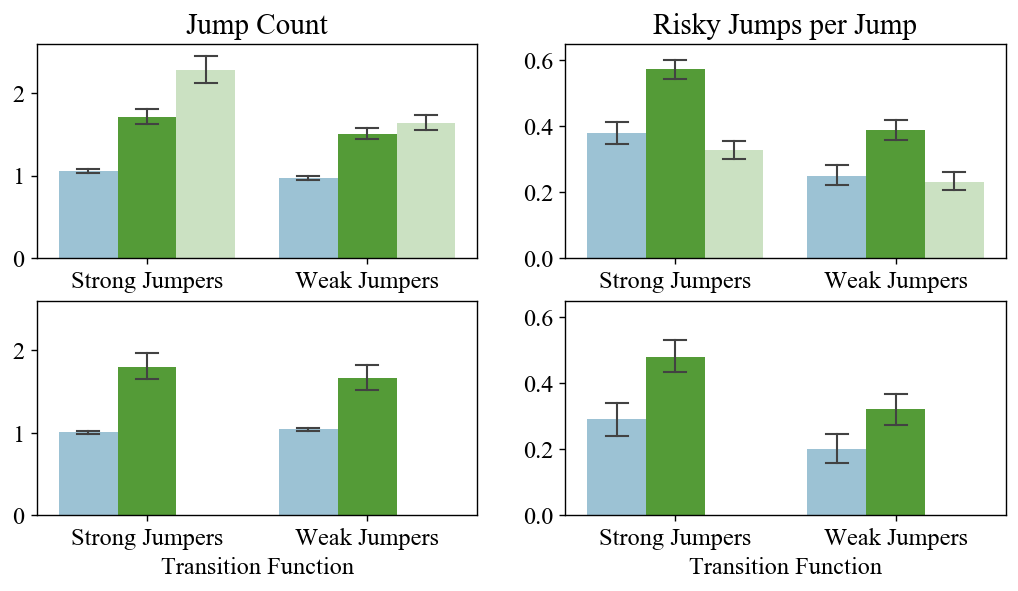

In [276]:
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 14


jump_df = exp_trials_stats[['grid', 'cond', 'participant', 'is_jump', 'tf']].\
    groupby(['participant', 'cond', 'grid', 'tf'])['is_jump'].sum().reset_index() #get jump count per round
riskyjump_df = exp_trials_stats[exp_trials_stats['is_jump']][['grid', 'cond', 'participant', 'is_risky_jump', 'tf']].reset_index()

fig, axes = plt.subplots(2,2, figsize=(10, 5), dpi=125)
sns.barplot(data=sim_trajs, y='n_jumps',
#             x='cond', 
            x='tf', hue='cond',
            palette=["#92C5DE", "#4DAC26", '#c9e6bd'], hue_order=['do', 'show', 'show-noint'], errwidth=1.2, capsize=.1, ax=axes[0][0])
sns.barplot(data=jump_df.groupby(['participant', 'grid', 'tf', 'cond'])['is_jump'].sum().reset_index(), 
            y='is_jump', 
#             x='cond', 
            x='tf', hue='cond',
            palette=["#92C5DE", "#4DAC26"], hue_order=['do', 'show', ""], errwidth=1.2, capsize=.1, ax=axes[1][0])
axes[0][0].set_ylim(0, 2.6)
axes[1][0].set_ylim(0, 2.6)

sns.barplot(data=sim_trajs, y='risky_jumps_per_jump', 
#             x='cond', 
            x='tf', hue='cond',
            palette=["#92C5DE", "#4DAC26", "#c9e6bd"], hue_order=['do', 'show', 'show-noint'], errwidth=1.2, capsize=.1, ax=axes[0][1])
sns.barplot(data=riskyjump_df.groupby(['participant', 'grid', 'tf', 'cond'])['is_risky_jump'].apply(lambda r: np.mean(r)).reset_index(), 
            y='is_risky_jump',  
#             x='cond', 
            x='tf', hue='cond',
            palette=["#92C5DE", "#4DAC26"], hue_order=['do', 'show', ""], errwidth=1.2, capsize=.1, ax=axes[1][1])
axes[0][1].set_ylim(0, .65)
axes[1][1].set_ylim(0, .65)
for ax in axes.flatten():
    ax.legend().remove()
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticklabels(['Strong Jumpers', 'Weak Jumpers'])
axes[1][0].set_xlabel("Transition Function")
axes[1][1].set_xlabel("Transition Function")
axes[0][0].set_title("Jump Count")
axes[0][1].set_title("Risky Jumps per Jump")

# Exp trajs in belief-space analyses

In [10]:
exp_trajs.groupby(['cond'])[[
    'b.target', 'b2.target', 'b2j.target', 'b2j.com']].agg(['mean', 'sem'])

b.target           b2.target           b2j.target             b2j.com  \
          mean       sem      mean       sem       mean       sem      mean   
cond                                                                          
do    0.623618  0.012238  0.624032  0.018200   0.636417  0.012912  0.263216   
show  0.707764  0.012258  0.736892  0.016028   0.722738  0.012859  0.436829   

                
           sem  
cond            
do    0.010746  
show  0.014759

In [11]:
exp_trajs[
    ['cond', 'grid', 'tf', 'participant', 'round',
     'b.target', 'b2.target', 'b2j.target', 'b2j.com']].\
    to_csv("./_comps/exp_traj_beliefs.csv")

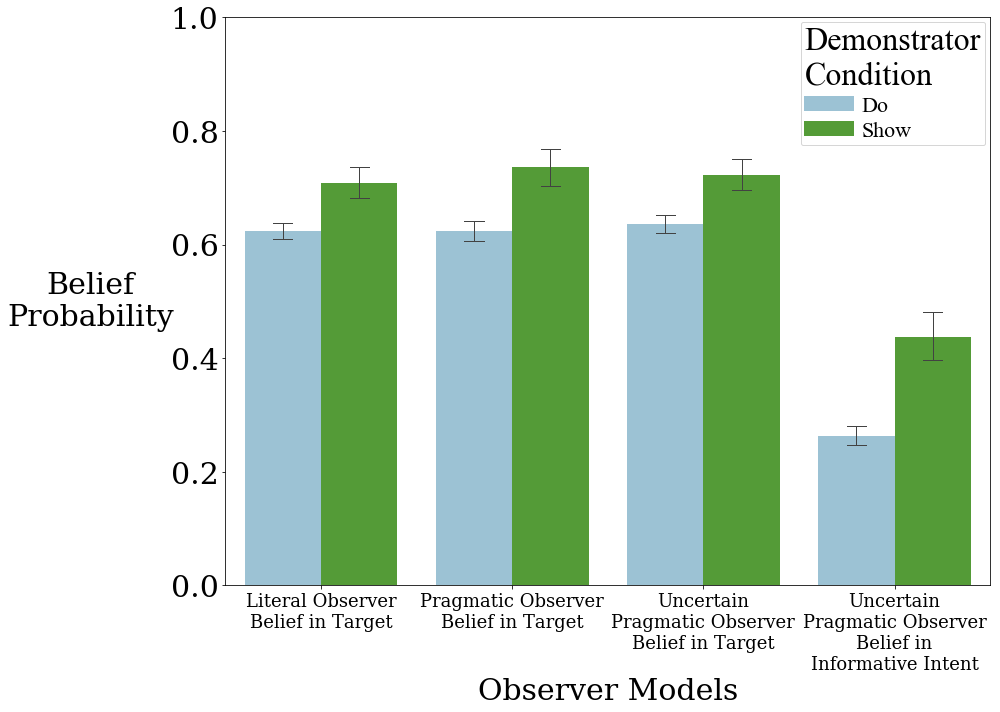

In [12]:
from matplotlib import rc
import matplotlib

exp_mean_btarg = exp_trajs.groupby(['cond', 'participant'])[[
    'b.target', 'b2.target', 'b2j.target', 'b2j.com']].mean().reset_index()
exp_mean_btarg = exp_mean_btarg.melt(
    id_vars=['participant', 'cond'],
    var_name='obs_type', value_name='belief')

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
g = sns.barplot(
    ax=ax,
    data=exp_mean_btarg,
    x='obs_type',
    y='belief',
    hue='cond',
    errwidth=1,
    capsize=.1,
    ci=95,
    order=['b.target', 'b2.target', 'b2j.target', 'b2j.com'],
    hue_order=['do', 'show'],
    palette=["#92C5DE", "#4DAC26"]
)
plt.ylim(0, 1)
plt.ylabel("Belief\nProbability", 
           fontsize=30, 
           fontname="Times New Roman", 
           rotation=0, 
           va='center', 
           labelpad=80,
           family='serif'
          )
plt.yticks(fontsize=30, 
           family='serif',
#            fontname="Times New Roman"
          )
g.set(xticklabels=['Literal Observer\nBelief in Target',
                   'Pragmatic Observer\nBelief in Target', 
                   'Uncertain\nPragmatic Observer\nBelief in Target',
                   'Uncertain\nPragmatic Observer\nBelief in\nInformative Intent'])
plt.xticks(fontsize=18, family='serif')
g.set_xlabel("Observer Models", 
             fontsize=30,
             family='serif')

ax.get_legend().get_title().set_text("Demonstrator\nCondition")
ax.get_legend().get_texts()[0].set_text("Do")
g.legend_.legendHandles[0].set(width=50, x=-50, height=15)
g.legend_.get_texts()[0].set(x=-20)
ax.get_legend().get_texts()[1].set_text("Show")
g.legend_.legendHandles[1].set(width=50, x=-50, height=15)
g.legend_.get_texts()[1].set(x=-20)

plt.setp(ax.get_legend().get_texts(), fontsize='22', fontname="Times New Roman", ma='left') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='32', fontname="Times New Roman") # for legend title
plt.tight_layout()

plt.savefig("./_figures/exp2-human-belief-plan-results.eps")

# Risky Jump QQ Plot

In [13]:
from sklearn.utils import resample

def confint(col, resamples=1000, ci=95):
    bootmeans = [resample(col).mean() for r in range(resamples)]
    lower = np.percentile(bootmeans, (100-ci)/2)
    upper = np.percentile(bootmeans, ci+(100-ci)/2)
    mean = np.mean(bootmeans)
    return (mean - lower, upper - mean)

exp_items = exp_trajs.groupby(['cond', "grid", "tf"])["risky_jumps_per_jump"]\
    .agg(["mean", confint, "sem"]).reset_index()
sim_items = sim_trajs.groupby(['cond', "grid", "tf"])["risky_jumps_per_jump"]\
    .agg(["mean", confint,"sem"]).reset_index()

In [14]:
expsim_items = exp_items.merge(sim_items, 
                               on=["cond", "grid", "tf"], 
                               suffixes=["_exp", "_sim"])

In [15]:
expsim_do = expsim_items[expsim_items["cond"] == "do"]
del expsim_do['cond']
expsim_show = expsim_items[expsim_items["cond"] == "show"]
del expsim_show['cond']
expsim_items_wide = expsim_do.merge(expsim_show, on=["grid", "tf"],
                                    suffixes=["_do", "_show"])

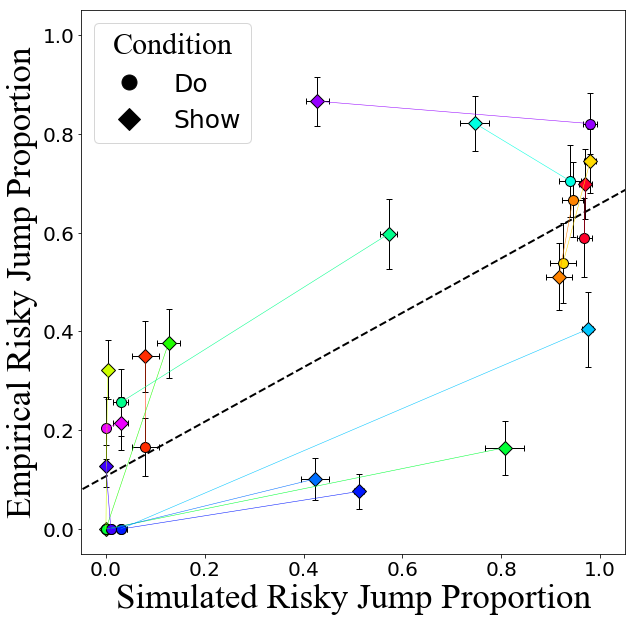

In [16]:
#plot
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy.stats import linregress
lr = linregress(expsim_items[['mean_sim', 'mean_exp']])

colorrange = plt.get_cmap('gist_rainbow')
color_norm = colors.Normalize(vmin=0, vmax=16)
value_map = cmx.ScalarMappable(norm=color_norm, cmap=colorrange)
legend_ele = []
legend_labels = []

fig, ax = plt.subplots(1,1, figsize=(10, 10))
ci = 0
for _, row in expsim_items_wide.iterrows():
    gridtf = row['grid'] + "-" + row['tf']
    gridtf_color = value_map.to_rgba(ci)
    y0, x0 = row['mean_exp_do'], row['mean_sim_do']
    y1, x1 = row['mean_exp_show'], row['mean_sim_show']
    ax.annotate('', xy=(x1, y1), xytext=(x0, y0),
                xycoords='data', textcoords='data',
                arrowprops=dict(
                    linewidth=.01,
#                     arrowstyle="-",
                    color=gridtf_color,
                    headlength=.1,
                    width=.5,
#                     connectionstyle="arc3"
                ))
    ele = plt.errorbar(
                 row['mean_sim_do'], row['mean_exp_do'],
                 np.array([row['sem_exp_do'],]).T, 
                 np.array([row['sem_sim_do'],]).T,
                 capsize=3, capthick=1, elinewidth=1, fmt='o',
                 ecolor='k', color=gridtf_color,
                 barsabove=False, ms=10, mec='k')
    legend_ele.append(ele[0])
    legend_labels.append(gridtf)
    plt.errorbar(row['mean_sim_show'], row['mean_exp_show'],
                 np.array([row['sem_exp_show'],]).T,
                 np.array([row['sem_sim_show'],]).T,
                 capsize=3, capthick=1, elinewidth=1, fmt='D',
                 ecolor='k', color=gridtf_color,
                 barsabove=False, ms=10, mec='k')
#     if ci == 4: #skip yellow
#         ci += 1
    ci += 1

# plt.plot([-1, 2], [-1, 2], '--k', linewidth=.5)
plt.plot([-1, 2], 
         np.multiply([-1, 2], [lr.slope, lr.slope]) + lr.intercept, 
         '--k', linewidth=2)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
ax.set_aspect('equal', 'box')
# legend0 = plt.legend(legend_ele, legend_labels, fontsize=20, 
#                     title='Trial')
# plt.setp(legend0.get_title(),fontsize=30, fontname="Times New Roman")
plt.ylabel('Empirical Risky Jump Proportion', fontsize=35, fontname="Times New Roman")
plt.xlabel('Simulated Risky Jump Proportion', fontsize=35, fontname="Times New Roman")
_ = plt.setp(ax.get_xticklabels(), fontsize=20)
_ = plt.setp(ax.get_yticklabels(), fontsize=20)

import matplotlib.lines as mlines

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                             markersize=15, label='Do')
black_diamond = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                             markersize=15, label='Show')

legend1 = plt.legend(handles=[black_circle, black_diamond], fontsize=25, 
                     title='Condition', loc=0)
plt.setp(legend1.get_title(),fontsize=30, fontname="Times New Roman")
# plt.gca().add_artist(legend0)
plt.savefig('./_figures/exp2-entropy-qq.eps')

# Analysis of Exp2b judgments

In [17]:
exp_learner_resp = pd.read_pickle("../data/exp2b-responses.pd.pkl")

# Comparison of Human-Model and Human-Human learning

In [18]:
exp_learner_resp.groupby(['demonstrator_cond', 'observer_cond'])['correct'].mean()

demonstrator_cond  observer_cond
do                 do               0.619469
                   show             0.613472
show               do               0.714722
                   show             0.716794
Name: correct, dtype: float64

In [19]:
exp_obsmod_res = exp_trajs.melt(
    id_vars=['cond', 'participant', 'grid', 'tf'],
    value_vars=['b.target', 'b2.target'],
    var_name='obs_model', value_name='belief')

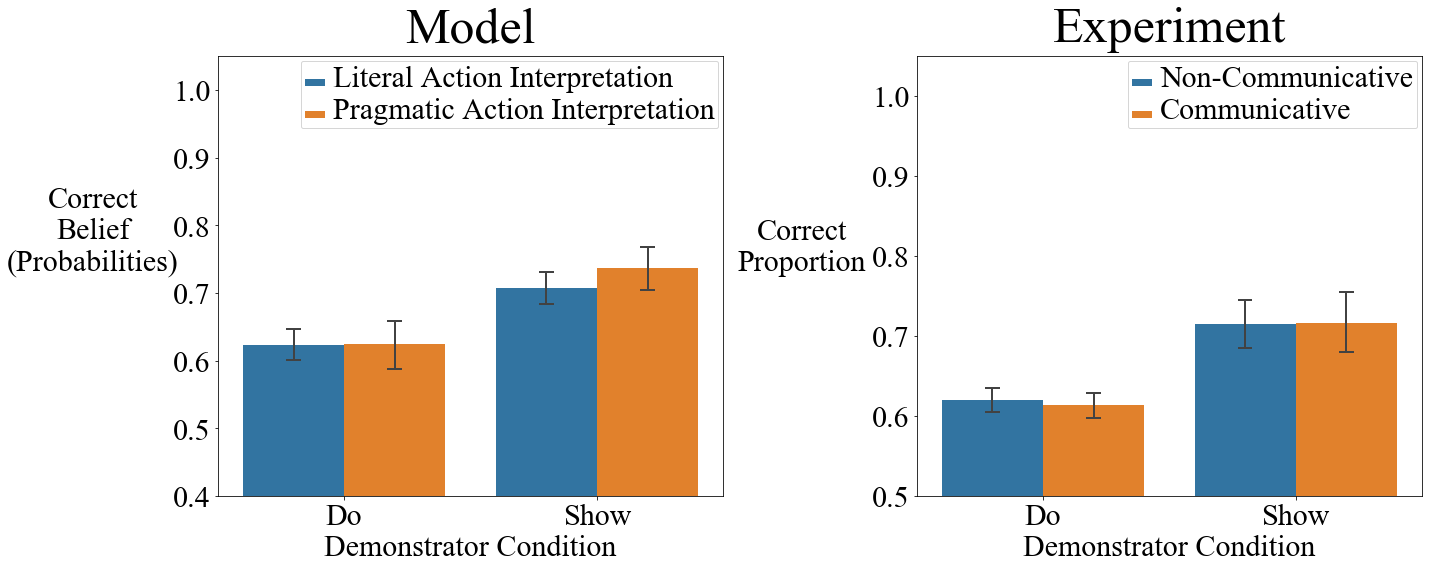

In [20]:
# rc('text', usetex=False)

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

g = sns.barplot(ax=ax[0],
            data=exp_obsmod_res, 
            x='cond',
            ci=95,
            y='belief', hue='obs_model',
            order=['do', 'show'],
            hue_order=['b.target', 'b2.target'],
               capsize=.05,
               errwidth=2)
plt.ylim(.5, 1.05)

ax[0].set_ylim(.4, 1.05)
_ = plt.setp(ax[0].get_xticklabels(), fontsize=30, fontname="Times New Roman")
_ = plt.setp(ax[0].get_yticklabels(), fontsize=30, fontname="Times New Roman")
ax[0].set_xticklabels(["Do", "Show"])
ax[0].set_xlabel('Demonstrator Condition', fontsize=30, fontname="Times New Roman")
ax[0].set_ylabel('Correct\nBelief\n(Probabilities)', 
                 fontsize=30, fontname="Times New Roman", 
                 rotation='horizontal', ha='center', labelpad=80)
# ax[0].get_legend().get_title().set_text("Observer Model")
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles=handles, labels=labels)

ax[0].get_legend().get_texts()[0].set_text("Literal Action Interpretation")
ax[0].get_legend().get_texts()[1].set_text("Pragmatic Action Interpretation")
plt.setp(ax[0].get_legend().get_texts(), fontsize='30', fontname="Times New Roman") # for legend text
# plt.setp(ax[0].get_legend().get_title(), fontsize='32', fontname="Times New Roman") # for legend title
tit = ax[0].set_title("Model", fontsize=50, fontname="Times New Roman")
tit.set_position([.5, 1.02])


g = sns.barplot(ax=ax[1],
                data=exp_learner_resp.groupby(['demonstrator_cond', 'observer_cond', 
                                      'learner_id'])['correct'].mean().reset_index(), 
                x='demonstrator_cond',
                ci=95,
                y='correct', hue='observer_cond',
                order=['do', 'show'],
                hue_order=['do', 'show'],
               capsize=.05,
               errwidth=2)
ax[1].set_ylim(.5, 1.05)
_ = plt.setp(ax[1].get_xticklabels(), fontsize=30, fontname="Times New Roman")
_ = plt.setp(ax[1].get_yticklabels(), fontsize=30, fontname="Times New Roman")
ax[1].set_xticklabels(["Do", "Show"])
ax[1].set_xlabel('Demonstrator Condition', fontsize=30, fontname="Times New Roman")
ax[1].set_ylabel('Correct\nProportion', fontsize=30, fontname="Times New Roman", 
           rotation='horizontal', ha='center', labelpad=70)
# ax[1].get_legend().get_title().set_text("Observer Condition")
handles, labels = ax[0].get_legend_handles_labels()
ax[1].legend(handles=handles, labels=labels)

ax[1].get_legend().get_texts()[0].set_text("Non-Communicative")
ax[1].get_legend().get_texts()[1].set_text("Communicative")
plt.setp(ax[1].get_legend().get_texts(), fontsize='30', fontname="Times New Roman") # for legend text
# plt.setp(ax[1].get_legend().get_title(), fontsize='32', fontname="Times New Roman") # for legend title
tit = ax[1].set_title("Experiment", fontsize=50, fontname="Times New Roman")
tit.set_position([.5, 1.02])

plt.subplots_adjust(wspace=.5)
plt.tight_layout()
plt.savefig("./_figures/exp2b_results.eps")